In [1]:
import os
import numpy as np # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf # type: ignore
import json
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.metrics import roc_curve, auc # type: ignore
from sklearn.decomposition import PCA
from visualizations import *

/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = []
with open('../json/reviews_Kindle_Store_5.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))


df = pd.DataFrame(data)
df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']]
df.dropna(inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
item_enc = LabelEncoder()

clean_df = pd.DataFrame()

df['user'] = user_enc.fit_transform(df['reviewerID'])
df['item'] = item_enc.fit_transform(df['asin'])
df['rating'] = df['overall']


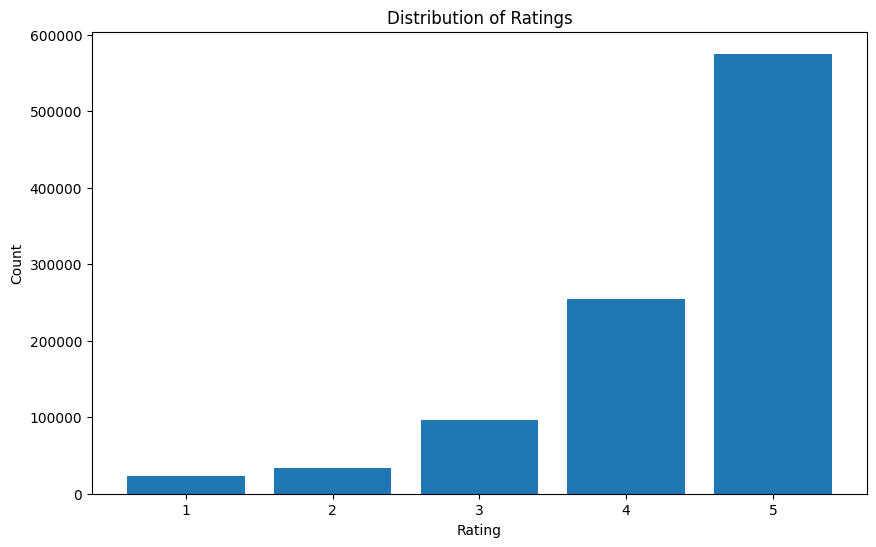

In [4]:
plot_rating_distribution(df)

In [5]:
clean_df = df[['user', 'item', 'rating']][df['rating'] >= 3.0]
clean_df

,user,item,rating
0,7773,0,5.0
1,61894,0,4.0
2,53977,0,4.0
3,8128,0,5.0
4,50527,0,4.0
...,...,...,...
982614,35142,61933,5.0
982615,4097,61933,5.0
982616,18464,61933,5.0
982617,5981,61933,5.0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['item'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float).view(-1, 1)
        # Normalize ratings for BCE loss
        self.ratings = (self.ratings - 1) / 4.0  # Assuming ratings are 1-5
        
    def __len__(self):
        return len(self.users)
        
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [23]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dimension=8, mlp_layers=[16,8], dropout=0.3):
        """ 
        num_users: number of users
        num_items: number of items
        embedding_dimension: dimension of the embeddings for the matrix factorization
        mlp_layers: sizes of hidden mulit-layer-perceptron
        dropout: dropout probability for regularization
        """
        super(NCF, self).__init__()

        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(dropout)

        #Matrix factorization embeddings
        self.user_embeddings_mf = nn.Embedding(num_users, embedding_dimension)
        self.item_embeddings_mf = nn.Embedding(num_items, embedding_dimension)

        #multi-layer perceptron embeddings
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dimension)
        self.item_embeddings_mlp = nn.Embedding(num_items, embedding_dimension)

        #MLP layers with batch normalization
        mlp_modules = []
        input_size = embedding_dimension * 2
        for layer_size in mlp_layers:
            mlp_modules.append(nn.Linear(input_size, layer_size))
            mlp_modules.append(nn.BatchNorm1d(layer_size))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(p=dropout))
            input_size = layer_size
        
        self.mlp = nn.Sequential(*mlp_modules)

        predict_size = embedding_dimension + mlp_layers[-1]
        
        # Final prediction layer -> output single score
        self.final_layer = nn.Sequential(
            nn.Linear(predict_size, 1),
            nn.Sigmoid()
        )

    def forward(self, user_ids, item_ids):
        """
        user_ids: [batch_size]
        item_ids: [batch_size]
        returns: predicted score [batch_size, 1]
        """
        # GMF part
        user_gmf = self.dropout(self.user_embeddings_mf(user_ids))
        item_gmf = self.dropout(self.item_embeddings_mf(item_ids))
        gmf_output = user_gmf * item_gmf
        
        # MLP part
        user_mlp = self.dropout(self.user_embeddings_mlp(user_ids))
        item_mlp = self.dropout(self.item_embeddings_mlp(item_ids))
        mlp_input = torch.cat((user_mlp, item_mlp), dim=1)
        mlp_output = self.mlp(mlp_input)

        # Concatenate GMF & MLP
        concat = torch.cat((gmf_output, mlp_output), dim=1)
        
        # Final layer
        preds = self.final_layer(concat)
        return preds

In [9]:
def leave_one_out_split(df):
    # Sort by user and (optionally) timestamp or item if available
    df = df.sort_values(by=["user", "item"])  # if no timestamp

    test_rows = []
    train_rows = []

    # Leave the last interaction (or any 1) per user for test set
    for user, group in df.groupby("user"):
        test_rows.append(group.iloc[-1])      # Last rating to test
        train_rows.append(group.iloc[:-1])    # All others to train

    test_df = pd.DataFrame(test_rows)
    train_df = pd.concat(train_rows)

    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [13]:
def data_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    df = df.sort_values(by=["user", "item"]) 
    unique_users = df['user'].unique()

    #for this dataset, we will split the data into train/val and test
    #we will use 80% of users for train/val and include some of their interactions in test
    #the remaining 20% of users will only appear in test (cold-start scenario)
    np.random.seed(42)  # For reproducibility
    train_val_users = np.random.choice(
        unique_users, 
        size=int(0.8 * len(unique_users)), 
        replace=False
    )
    cold_start_users = np.array(list(set(unique_users) - set(train_val_users)))
    
    #create dataframes for each user group
    train_val_df = df[df['user'].isin(train_val_users)]
    cold_start_df = df[df['user'].isin(cold_start_users)]
    
    #shuffle the interactions for train/val so that the data is more random
    train_val_indices = train_val_df.index.values
    np.random.shuffle(train_val_indices)
    
    train_size = int(len(train_val_indices) * (train_ratio / (train_ratio + val_ratio)))
    
    train_indices = train_val_indices[:train_size]
    val_indices = train_val_indices[train_size:]
    
    train_df = df.loc[train_indices]
    val_df = df.loc[val_indices]
    
    # For test set, combine some interactions from train/val users and all cold-start users
    # Sample some interactions from train/val users for the test set
    train_val_test_size = int(len(train_val_df) * (test_ratio / (train_ratio + val_ratio + test_ratio)))
    train_val_test_indices = np.random.choice(train_val_indices, size=train_val_test_size, replace=False)
    
    # Combine with cold-start users
    test_df = pd.concat([df.loc[train_val_test_indices], cold_start_df])
    
    print(f"Training set: {len(train_df)} interactions, {train_df['user'].nunique()} users")
    print(f"Validation set: {len(val_df)} interactions, {val_df['user'].nunique()} users")
    print(f"Test set: {len(test_df)} interactions, {test_df['user'].nunique()} users")
    print(f"Test set includes {cold_start_df['user'].nunique()} new users not seen during training")
    
    return train_df, val_df, test_df
    


In [ ]:
#old training loop
# train, test = leave_one_out_split(clean_df)

# train_dataset = RatingDataset(train)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# test_dataset = RatingDataset(test)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# # Sample hyperparameters
# num_users = clean_df['user'].max() + 1  # +1 because 0-indexed
# num_items = clean_df['item'].max() + 1  # +1 because 0-indexed
# embedding_dimension = 8

# model = NCF(num_users, num_items, embedding_dimension=embedding_dimension, mlp_layers=[16, 8])
# model.train()  # set to training mode

# criterion = nn.BCELoss()  #This will classify the reviews as either positive or negative
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) #L2 regularization to prevent overfitting

# """ Plotting data structures """
# # Plotting loss over time
# running_loss = []

# # Training loop (will overfit)
# epochs = 20
# for epoch in range(epochs):
#     total_loss = 0.0
#     for batch_users, batch_items, batch_ratings in train_loader:
#         optimizer.zero_grad()
#         predictions = model(batch_users, batch_items)
#         loss = criterion(predictions, batch_ratings)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item() * batch_users.size(0)  # Weighted by batch size

#     avg_loss = total_loss / len(train_dataset)

#     # append the loss to the running_loss list
#     running_loss.append(avg_loss)
    
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.3813
Epoch 2/20, Loss: 0.3457
Epoch 3/20, Loss: 0.3361
Epoch 4/20, Loss: 0.3347
Epoch 5/20, Loss: 0.3342
Epoch 6/20, Loss: 0.3340
Epoch 7/20, Loss: 0.3340
Epoch 8/20, Loss: 0.3342
Epoch 9/20, Loss: 0.3341
Epoch 10/20, Loss: 0.3339
Epoch 11/20, Loss: 0.3339
Epoch 12/20, Loss: 0.3340
Epoch 13/20, Loss: 0.3340
Epoch 14/20, Loss: 0.3341
Epoch 15/20, Loss: 0.3342
Epoch 16/20, Loss: 0.3340
Epoch 17/20, Loss: 0.3340
Epoch 18/20, Loss: 0.3340
Epoch 19/20, Loss: 0.3339
Epoch 20/20, Loss: 0.3337


In [14]:
train, val, test = data_split(clean_df)

train_dataset = RatingDataset(train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = RatingDataset(val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = RatingDataset(test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Training set: 609046 interactions, 54474 users
Validation set: 130511 interactions, 41766 users
Test set: 296847 interactions, 52868 users
Test set includes 13631 new users not seen during training


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_users = clean_df['user'].max() + 1  
num_items = clean_df['item'].max() + 1  
embedding_dimension = 8

model = NCF(num_users, num_items, embedding_dimension=embedding_dimension, mlp_layers=[16, 8])
model = model.to(device)

# BCE loss will classify the reviews as either positive or negative
criterion = nn.BCELoss()
# the optimizer will update the model parameters (parameters found online, will be tweaked)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
# Will reduce learning rate if validation loss doesn't improve
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
# Early stopping if validation loss doesn't improve for 3 epochs
best_val_loss = float('inf')
patience = 3
patience_counter = 0
    
running_losses = []
val_losses = []

num_epochs=50

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch_users, batch_items, batch_ratings in train_loader:
        batch_users = batch_users.to(device)
        batch_items = batch_items.to(device)
        batch_ratings = batch_ratings.to(device)
            
        optimizer.zero_grad()
        predictions = model(batch_users, batch_items)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
            
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
        optimizer.step()
        train_loss += loss.item() * batch_users.size(0)
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    running_losses.append(avg_train_loss)
        
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_users, batch_items, batch_ratings in val_loader:
            batch_users = batch_users.to(device)
            batch_items = batch_items.to(device)
            batch_ratings = batch_ratings.to(device)
                
            predictions = model(batch_users, batch_items)
            loss = criterion(predictions, batch_ratings)
            val_loss += loss.item() * batch_users.size(0)
        
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
        
    # Learning rate scheduling 
    scheduler.step(avg_val_loss)
        
   # Early stopping check if validation loss doesn't improve for 3 epochs
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best version of the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.3921, Val Loss: 0.3460
Epoch 2/50
Train Loss: 0.3430, Val Loss: 0.3381
Epoch 3/50
Train Loss: 0.3397, Val Loss: 0.3375
Epoch 4/50
Train Loss: 0.3394, Val Loss: 0.3383
Epoch 5/50
Train Loss: 0.3395, Val Loss: 0.3377
Early stopping triggered at epoch 6


/var/folders/xh/_tzk65hj6pn1zkd30431w60h0000gn/T/ipykernel_51548/1011986655.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

<All keys matched successfully>

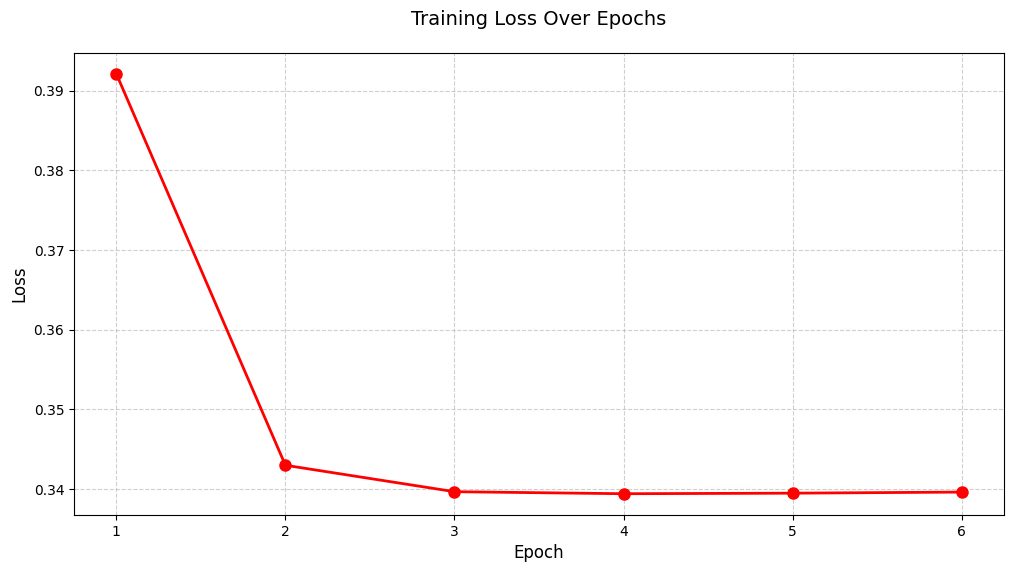

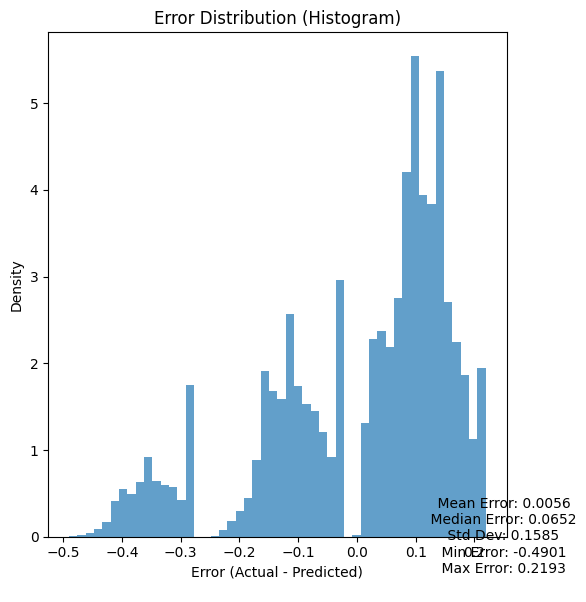

/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


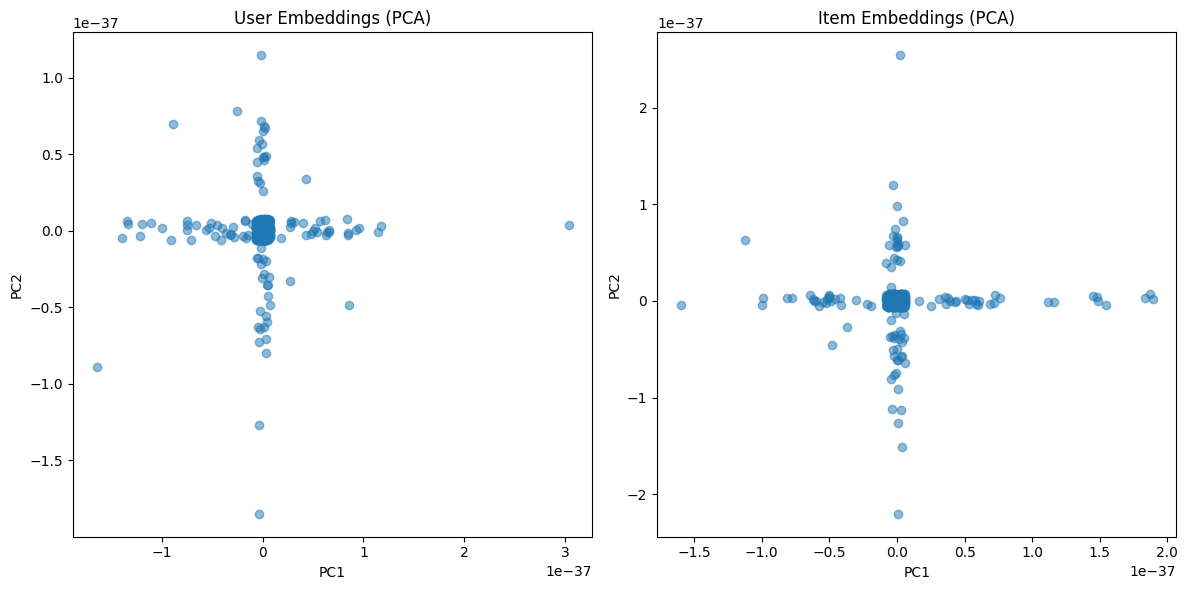

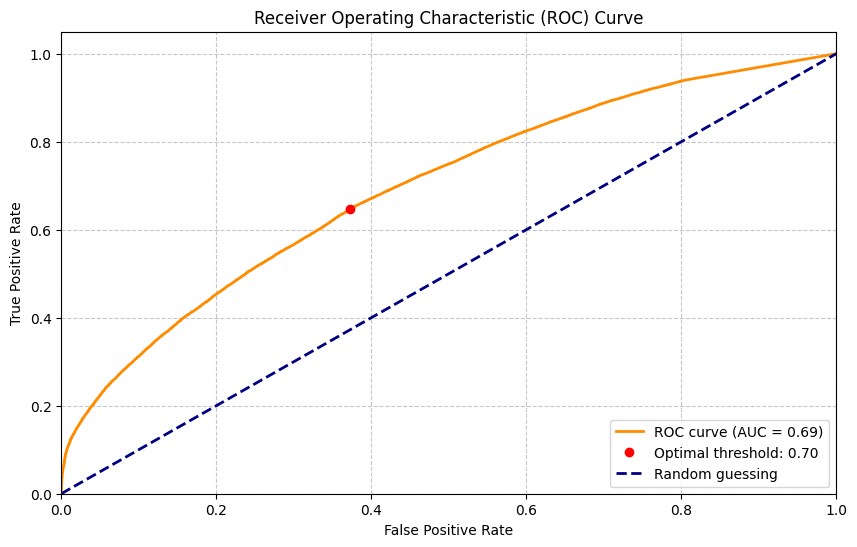

In [25]:
#use graph functions in visualizations.py
plot_training_history(running_losses)

plot_error_distribution(model, test_loader)

plot_embeddings(model, clean_df)

plot_roc_curve(model, test_loader, criterion)

In [26]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for batch_users, batch_items, batch_ratings in test_loader:
        predictions = model(batch_users, batch_items)
        test_loss += criterion(predictions, batch_ratings).item() * batch_users.size(0)
    
    avg_test_loss = test_loss / len(test_dataset)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.3515


In [30]:
def top_k_recommendations(model, user_id, item_ids=None, history=None, k=10):
    """
    Get top-k item recommendations for a given user.
    
    Args:
        model: Trained NCF model
        user_id: ID of the user to get recommendations for
        k: Number of recommendations to return
        exclude_interacted: Whether to exclude items the user has already interacted with
        item_ids: List of all item IDs. If None, will use all items in the model.
    
    Returns:
        tuple: (top_k_items, top_k_scores) where:
            top_k_items: List of k recommended item IDs
            top_k_scores: List of k predicted scores for the recommended items
    """
    device = next(model.parameters()).device
    
    # If item_ids not provided, use all items in the model
    if item_ids is None:
        item_ids = torch.arange(model.item_embeddings_mf.num_embeddings, device=device)
    
    # Create user tensor (repeat user_id for each item)
    user_tensor = torch.full((len(item_ids),), user_id, device=device)
    
    # Get predictions for all items
    with torch.no_grad():
        model.eval()
        predictions = model(user_tensor, item_ids)
        predictions = predictions.squeeze()
    
    # We are not inlcuding items the user has already interacted with
    if history is not None:
        interacted_items = df[df['user'] == user_id]['item'].unique().tolist()
        mask = torch.ones(len(item_ids), dtype=torch.bool, device=device)
        for item in interacted_items:
            mask[item] = False
        predictions = predictions[mask]
        item_ids = item_ids[mask]
    
    # Get top k items and their scores
    top_k_scores, top_k_indices = torch.topk(predictions, k)
    
    return item_ids[top_k_indices].cpu().numpy(), top_k_scores.cpu().numpy()
        
                    

In [34]:
def get_item_asin(item_id, item_encoder):
    return item_encoder.inverse_transform([item_id])[0]

def get_item_asins(item_ids, item_encoder):
    return item_encoder.inverse_transform(item_ids).tolist()

In [38]:
asins = item_enc.inverse_transform(top_k_recommendations(model, 1, history=None)[0]).tolist()
asins

['B00GKBIRVM',
 'B00F9AJXYA',
 'B00DI8TUHU',
 'B00HGEPEWC',
 'B00IA6QWP8',
 'B00E7XUGM8',
 'B004Z1GHG6',
 'B00JYWX3D6',
 'B0092MT3Y6',
 'B00IWQ3M0Y']